In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)

In [34]:
df = pd.read_csv("/kaggle/input/loan-data/loan_data.csv")

print("Data Shape:", df.shape)
df.head()

Data Shape: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


BASIC EXPLORATION

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB


In [36]:
df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000
mean,134056.500000,48203.659176,0.120764,680.831732,15028.884002,12.357615,0.798422
std,77397.989374,26735.817913,0.068750,55.404553,6932.802588,2.008781,0.401180
min,0.000000,6002.430000,0.011000,395.000000,500.910000,3.660000,0.000000
25%,67028.250000,27897.190000,0.072000,646.000000,10281.410000,10.990000,1.000000
50%,134056.500000,46552.490000,0.096000,682.000000,15011.150000,12.370000,1.000000
75%,201084.750000,60981.320000,0.156000,719.000000,18872.210000,13.680000,1.000000
max,268113.000000,393381.740000,0.577000,849.000000,48959.950000,20.840000,1.000000


TARGET VARIABLE ANALYSIS

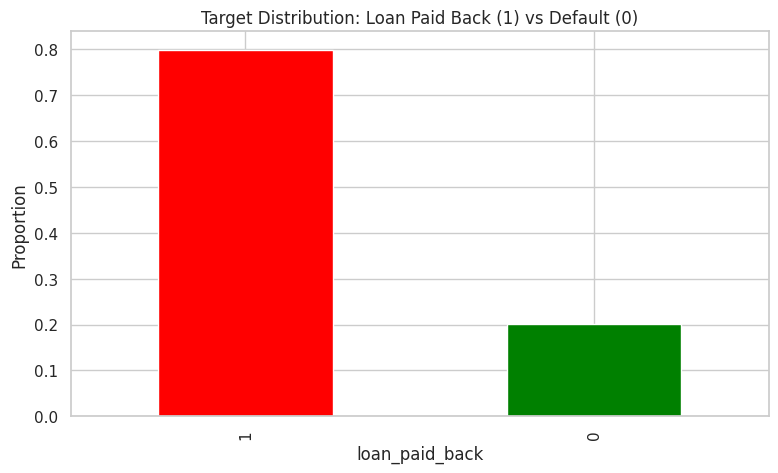

loan_paid_back
1    214068
0     54046
Name: count, dtype: int64
loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64


In [37]:
# Target Variable Analysis
df['loan_paid_back'].value_counts(normalize=True).plot(kind='bar', color=['red','green'])
plt.title("Target Distribution: Loan Paid Back (1) vs Default (0)")
plt.xlabel("loan_paid_back")
plt.ylabel("Proportion")
plt.show()

print(df['loan_paid_back'].value_counts())
print(df['loan_paid_back'].value_counts(normalize=True))


PREPROCESSING

In [38]:
# Separate features and target
X = df.drop(columns=['loan_paid_back', 'id'])
y = df['loan_paid_back']

# Identify column types
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [39]:
# Build a preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [40]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


MODEL TRAINING 

In [41]:
log_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=2000))
])

log_model.fit(X_train, y_train)
log_pred = log_model.predict_proba(X_test)[:,1]
log_auc = roc_auc_score(y_test, log_pred)

print("Logistic Regression AUC:", log_auc)


Logistic Regression AUC: 0.9119978702782789


In [42]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_pred)

print("Random Forest AUC:", rf_auc)


Random Forest AUC: 0.9126304470595727


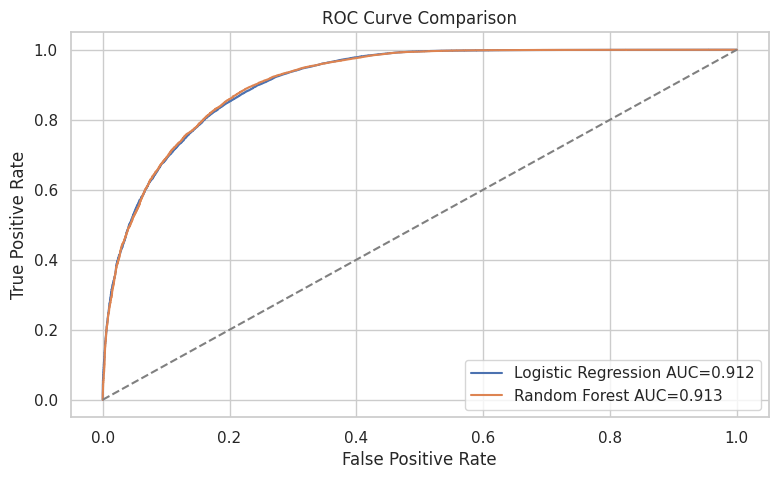

In [43]:
fpr1, tpr1, _ = roc_curve(y_test, log_pred)
fpr2, tpr2, _ = roc_curve(y_test, rf_pred)

plt.plot(fpr1, tpr1, label=f"Logistic Regression AUC={log_auc:.3f}")
plt.plot(fpr2, tpr2, label=f"Random Forest AUC={rf_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [44]:
def subgroup_auc(data, column, model):
    results = []
    for level in data[column].unique():
        subset = data[data[column] == level]
        if len(subset) < 20:
            continue
        X_sub = subset.drop(columns=['loan_paid_back','id'])
        y_sub = subset['loan_paid_back']
        pred = model.predict_proba(X_sub)[:,1]
        auc = roc_auc_score(y_sub, pred)
        results.append((level, auc))
    return pd.DataFrame(results, columns=[column, "AUC"]).sort_values("AUC")


  education_level       AUC
1        Master's  0.916506
2      Bachelor's  0.918191
3             PhD  0.919327
0     High School  0.919808
4           Other  0.924143


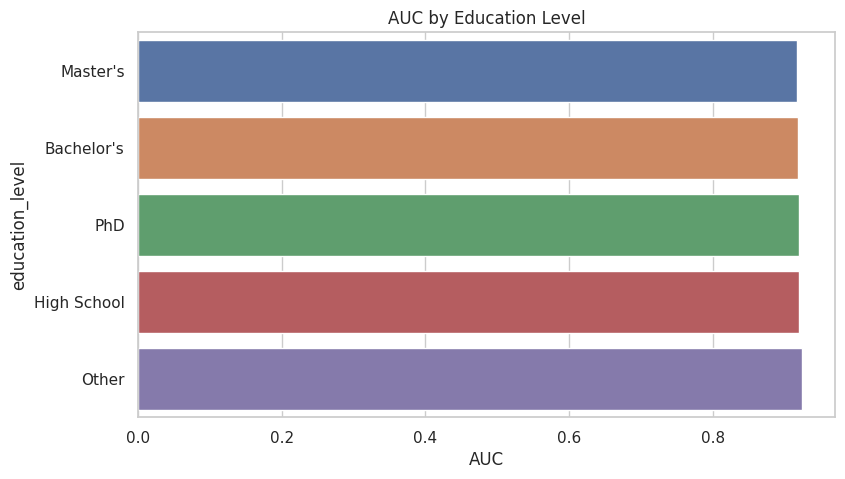

In [45]:
edu_auc = subgroup_auc(df, "education_level", rf_model)
print(edu_auc)

sns.barplot(data=edu_auc, x="AUC", y="education_level")
plt.title("AUC by Education Level")
plt.show()


Top 3 performing purposes:
  loan_purpose       AUC
6      Medical  0.920365
3    Education  0.920873
4     Vacation  0.930811

Bottom 3 performing purposes:
         loan_purpose       AUC
2                Home  0.917836
1  Debt consolidation  0.917954
5                 Car  0.918773


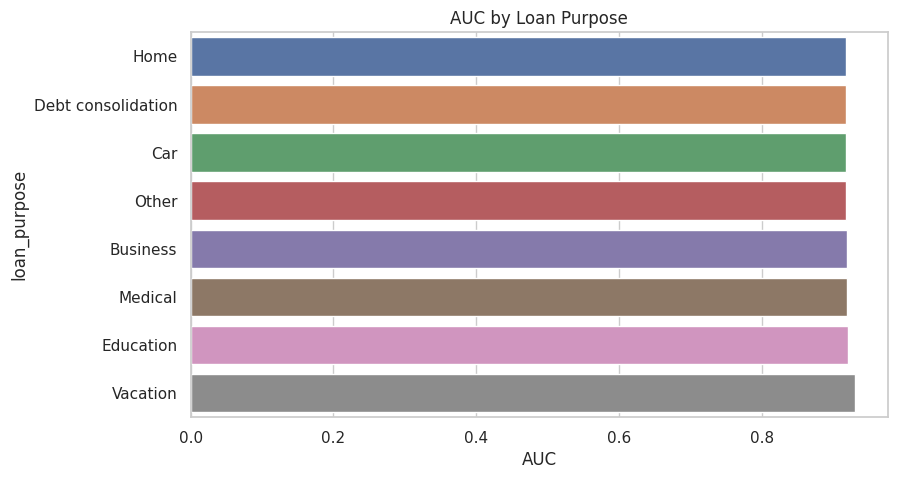

In [46]:
purpose_auc = subgroup_auc(df, "loan_purpose", rf_model)

print("Top 3 performing purposes:")
print(purpose_auc.tail(3))

print("\nBottom 3 performing purposes:")
print(purpose_auc.head(3))

sns.barplot(data=purpose_auc, x="AUC", y="loan_purpose")
plt.title("AUC by Loan Purpose")
plt.show()


In [47]:
purpose_auc = compute_subgroup_auc(df, "loan_purpose", preprocessor, best_model)
purpose_auc_sorted = purpose_auc.sort_values(by="AUC")
purpose_auc_sorted


,loan_purpose,AUC
2,Home,0.910378
7,Business,0.911612
5,Car,0.913031
6,Medical,0.913392
0,Other,0.914081
3,Education,0.914548
1,Debt consolidation,0.915053
4,Vacation,0.922302


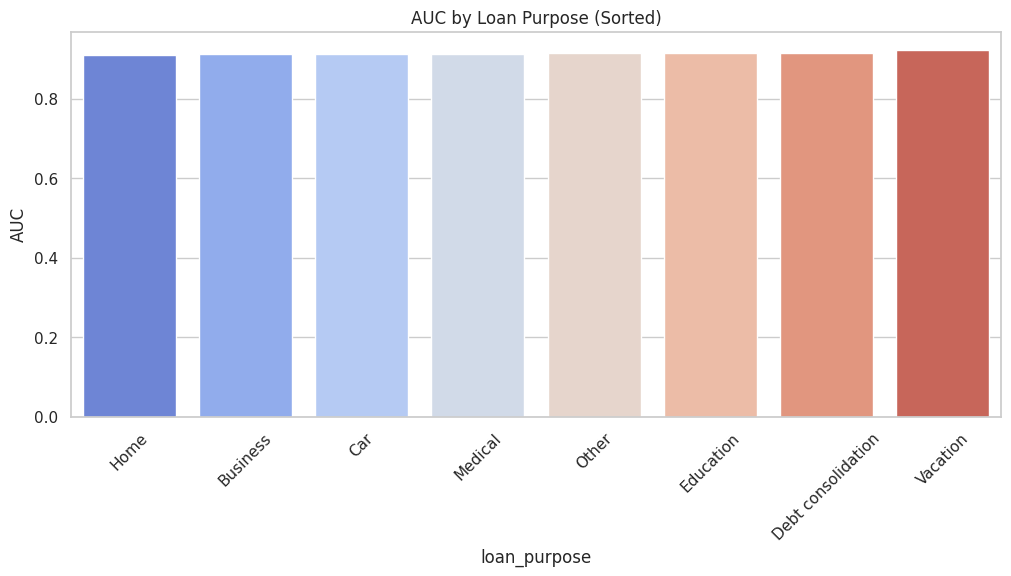

In [48]:
plt.figure(figsize=(12,5))
sns.barplot(data=purpose_auc_sorted, x="loan_purpose", y="AUC", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("AUC by Loan Purpose (Sorted)")
plt.show()


In [49]:
# Final predictions for test set
final_predictions = best_model.predict_proba(X_test_transformed)[:, 1]

submission_df = pd.DataFrame({
    "id": df.loc[X_test.index, "id"],
    "loan_paid_back_probability": final_predictions
})

submission_df.head()


,id,loan_paid_back_probability
104743,104743,0.971719
177605,177605,0.971672
3592,3592,0.935011
208588,208588,0.846151
16053,16053,0.953177
